In [51]:
from plots import *
from utils import train_step, val_step, Plot_ROC

import random
import numpy as np
from PIL import Image
import re, os, sys, cv2, json, random
from StepByStep import StepByStep
from tqdm import tqdm
from image_classification import generate_dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

# **Classifying Images**

## **Data Generation**

In [3]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

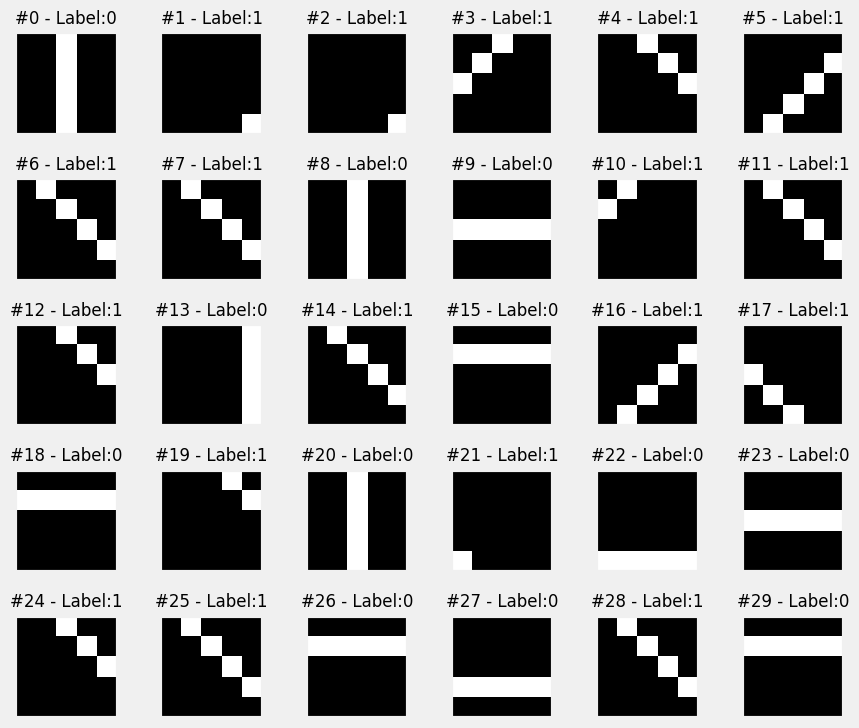

In [4]:
fig = plot_images(images, labels, n_plot=30)

## **Images and Channels**

In [5]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [6]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

In [7]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

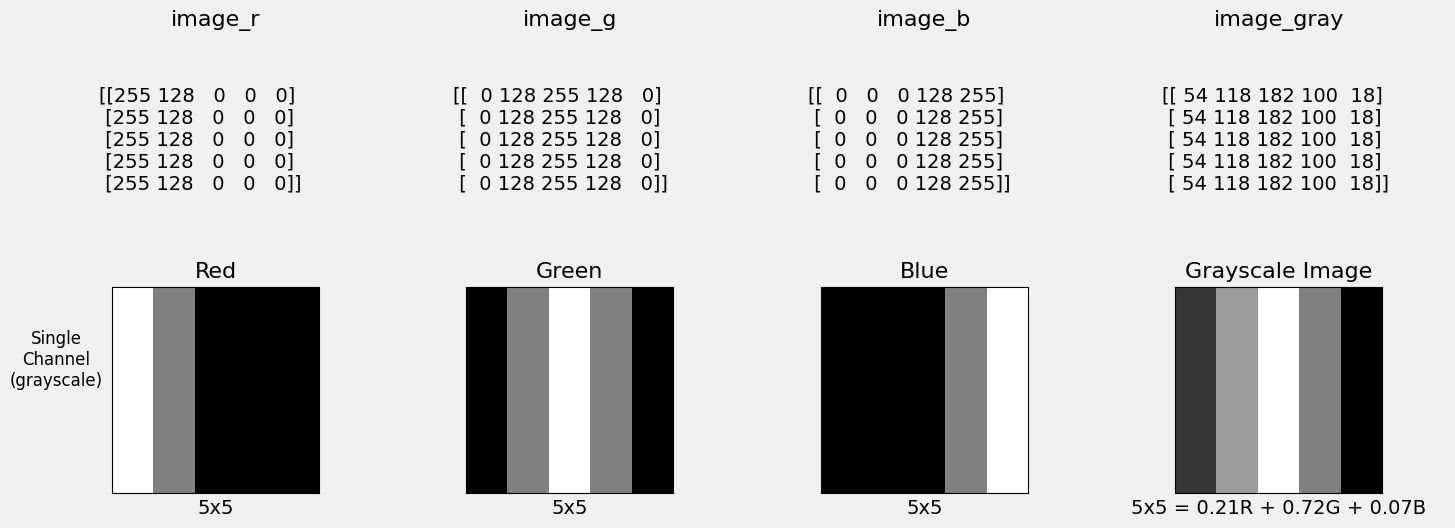

In [8]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

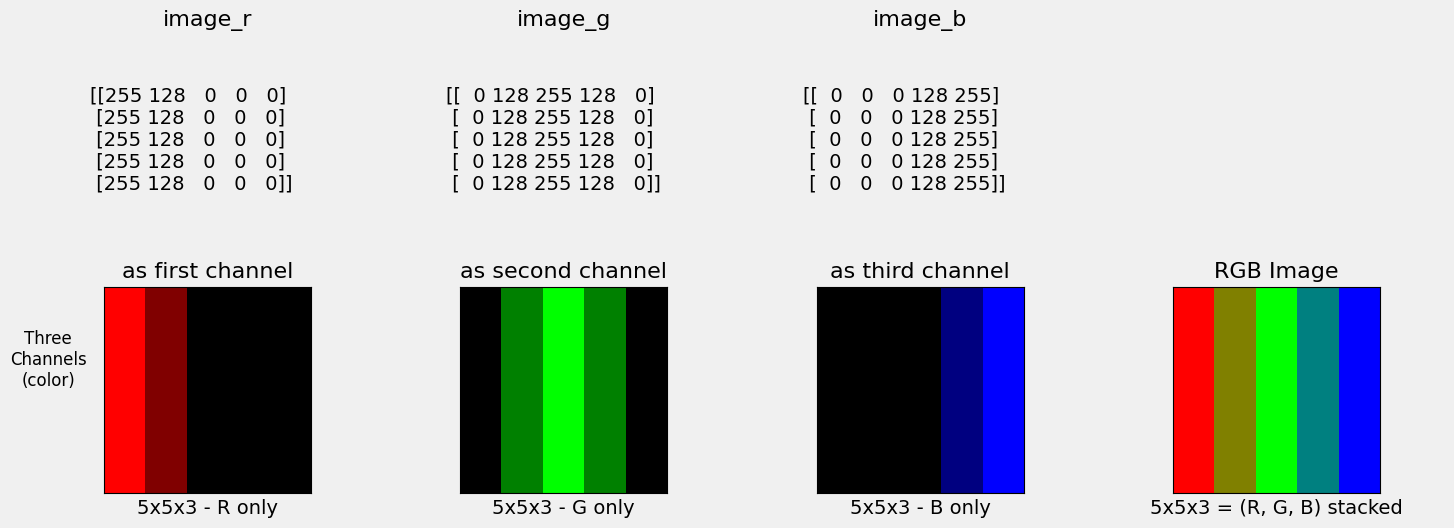

In [9]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

## **NCHW vs NHWC**

In [10]:
images.shape

(300, 1, 5, 5)

In [11]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [12]:
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [13]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

# **Torchvision**

## **Transforms**

In [14]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [15]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [16]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


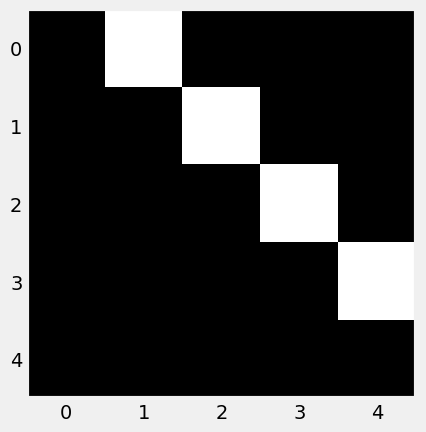

In [17]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

## **Transforms on Images**

In [18]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

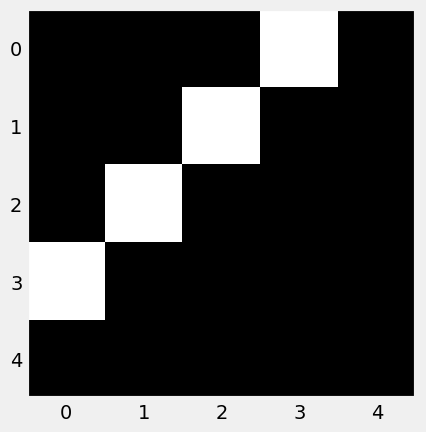

In [19]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

## **Transforms on Tensor**

In [21]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [22]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

## **Composing Transforms**

In [23]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

In [24]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [25]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


In [26]:
example_tensor = torch.as_tensor(example / 255).float()

## **Data Preparation**

In [27]:
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

## **Dataset Transforms**

In [29]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [30]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

## **SubsetRandomSampler**

In [31]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [32]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [34]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [35]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

In [36]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

## **Data Augmentation Transformations**

In [37]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [38]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [39]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [40]:
for x, y in train_loader:
    print(x.size())
    print(y.size())
    break

torch.Size([16, 1, 5, 5])
torch.Size([16, 1])


### **WeightedRandomSampler**

In [42]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


In [43]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

In [44]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [45]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [46]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [47]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [48]:
sampler = make_balanced_sampler(y_train_tensor)

### **Seeds and more (seeds)**

In [49]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

In [50]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

In [52]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass
    
setattr(StepByStep, 'set_seed', set_seed)

# **Putting It Together**

In [53]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## **Pixels as Features**

In [54]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [55]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


## **Model Configuration**

In [56]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [57]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

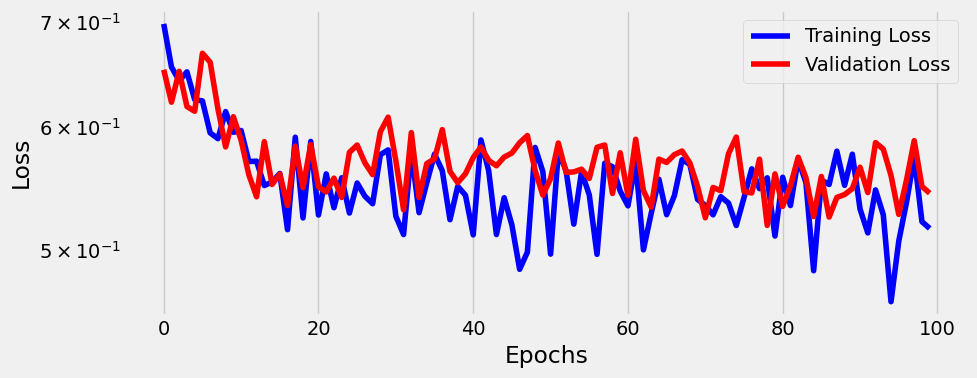

In [58]:
fig = sbs_logistic.plot_losses()

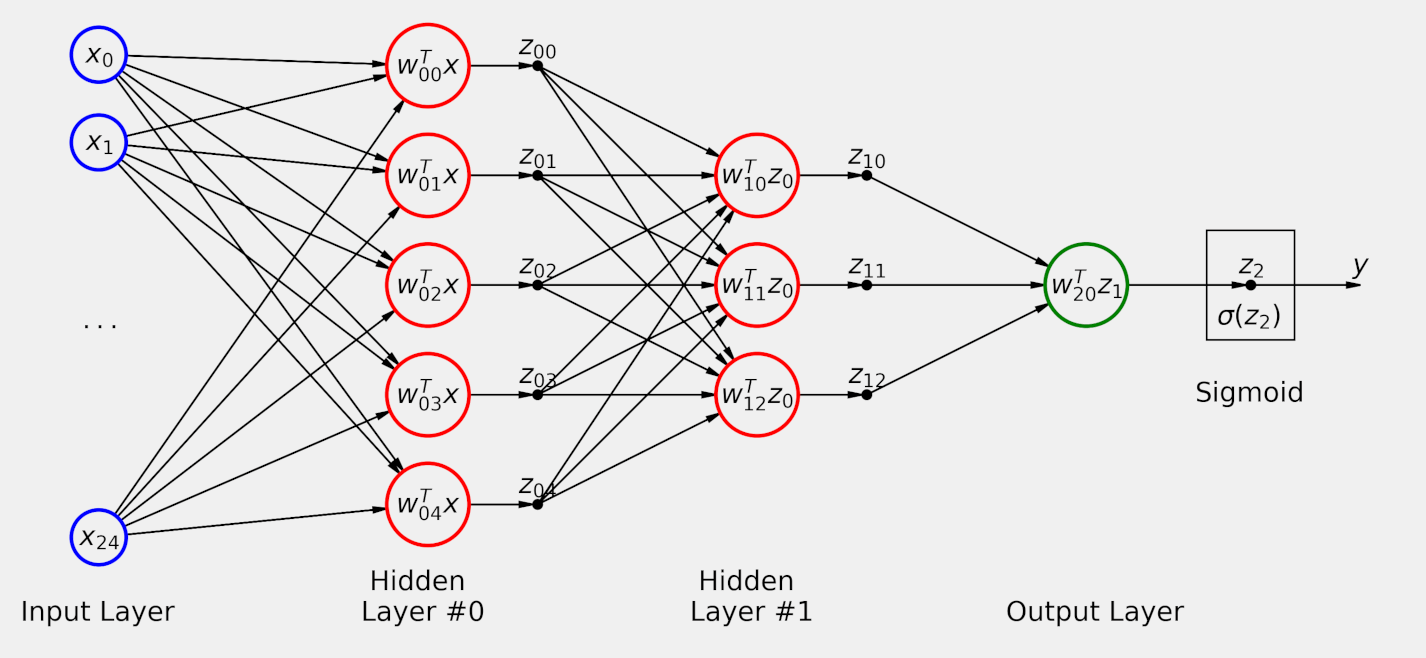

## **Model Configuration**

In [59]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

## **Model Training**

In [60]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

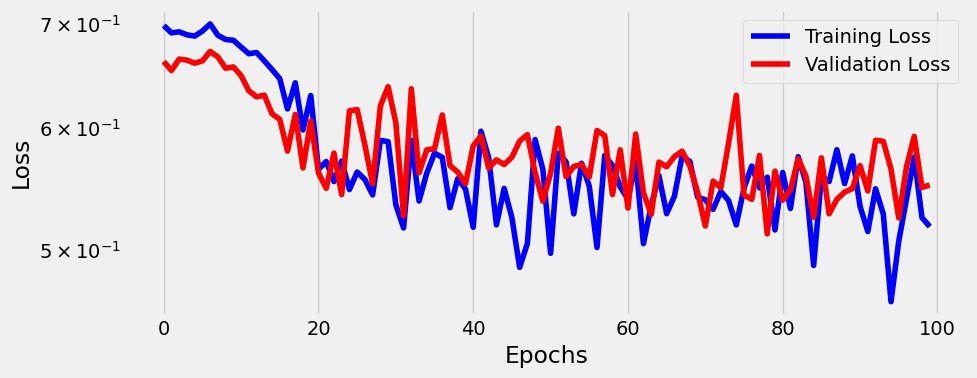

In [61]:
fig = sbs_nn.plot_losses()

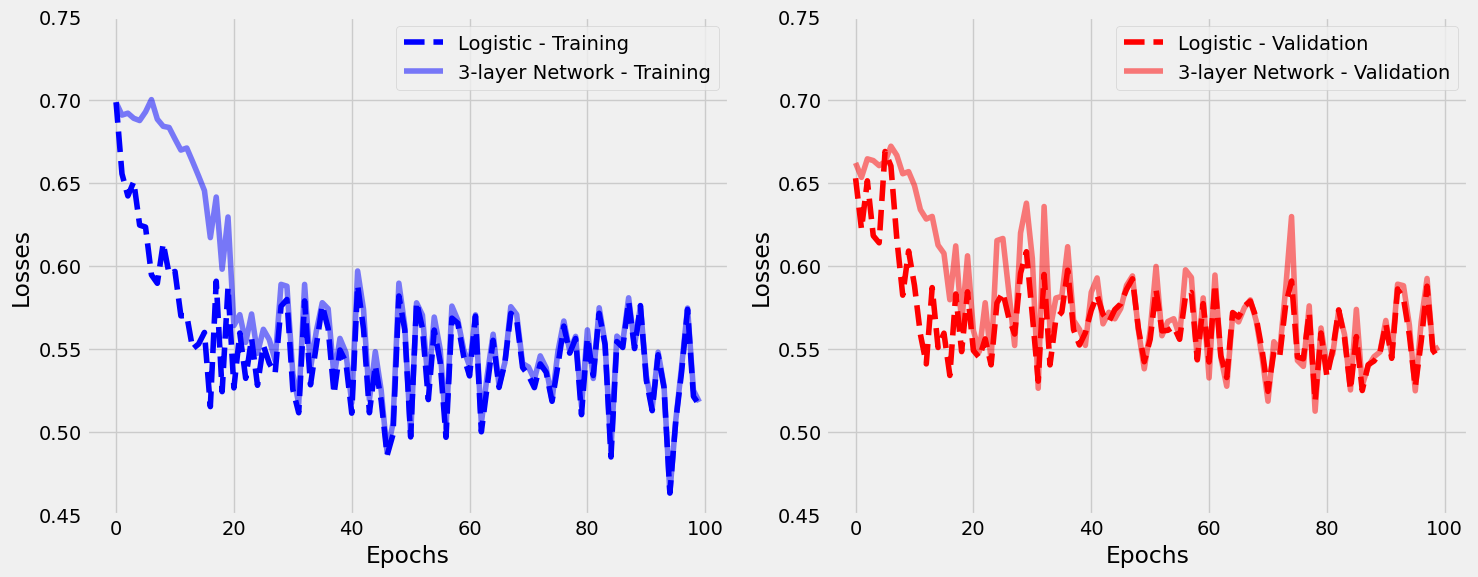

In [62]:
fig = figure5(sbs_logistic, sbs_nn)

## **Show Me the Code!**

In [63]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [64]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [65]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [66]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

torch.Size([1, 25])

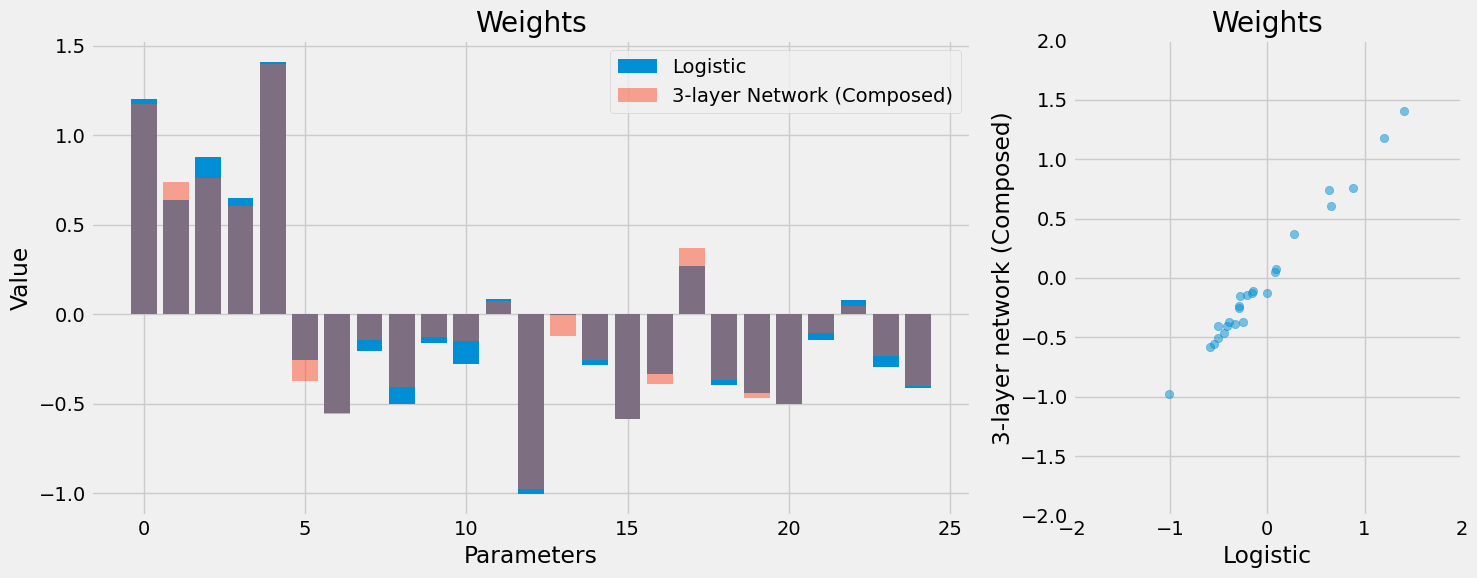

In [67]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

In [68]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [69]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

## **Weights as Pixels**

In [70]:
w_nn_hidden0.shape

torch.Size([5, 25])

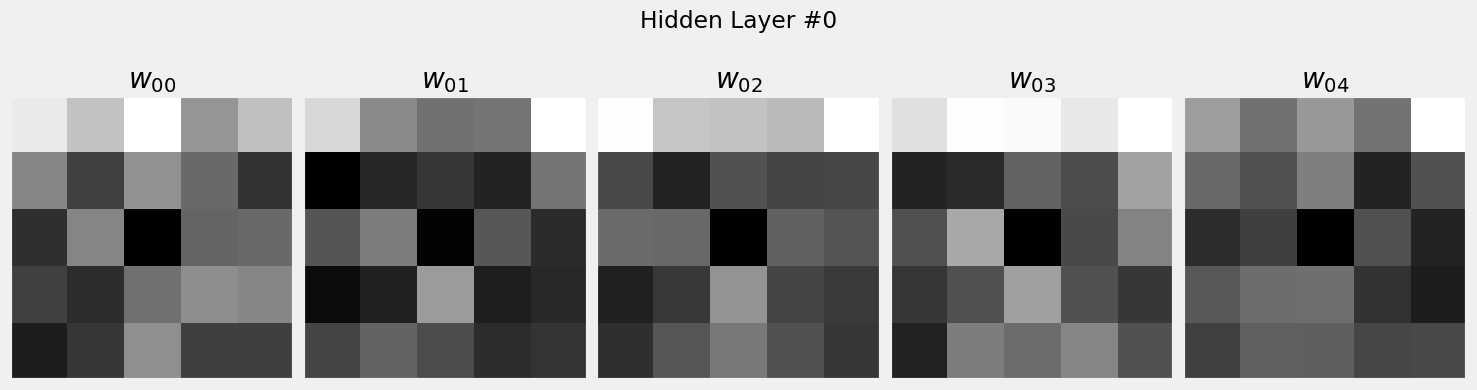

In [71]:
fig = figure7(w_nn_hidden0)

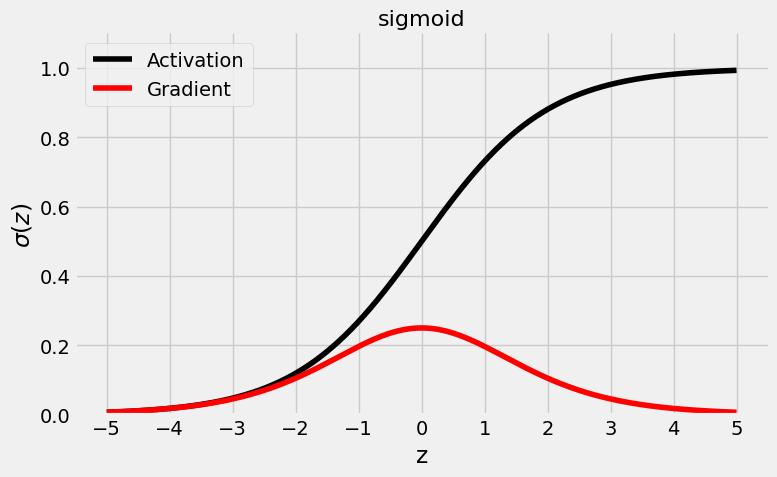

In [72]:
fig = plot_activation(torch.sigmoid)

In [73]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [74]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

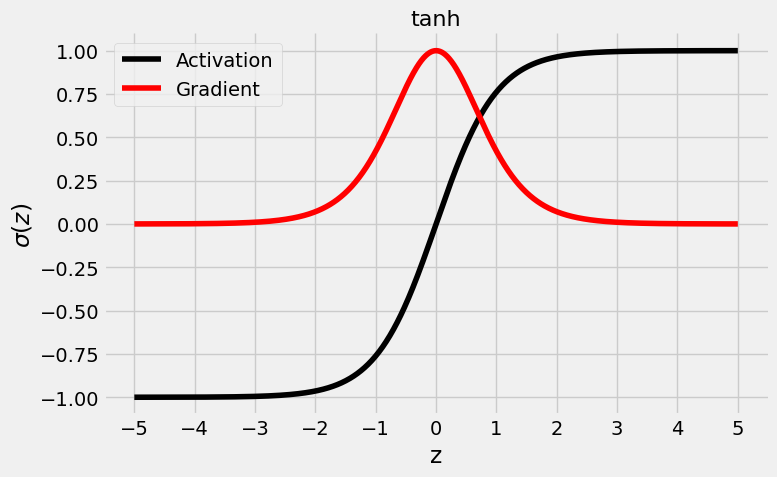

In [75]:
fig = plot_activation(torch.tanh)

In [76]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [77]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

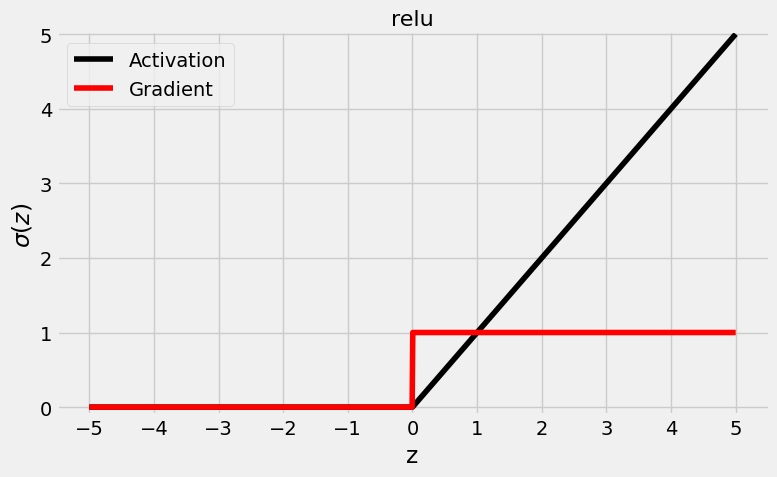

In [78]:
fig = plot_activation(torch.relu)

In [79]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [80]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [81]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

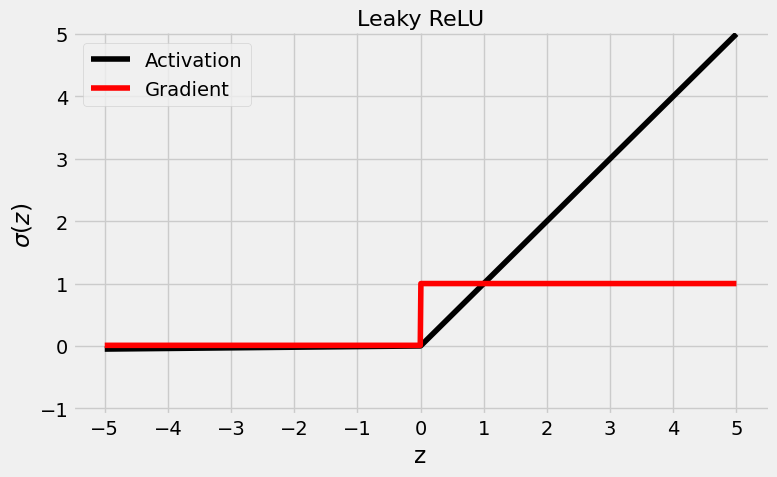

In [82]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

In [83]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [84]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

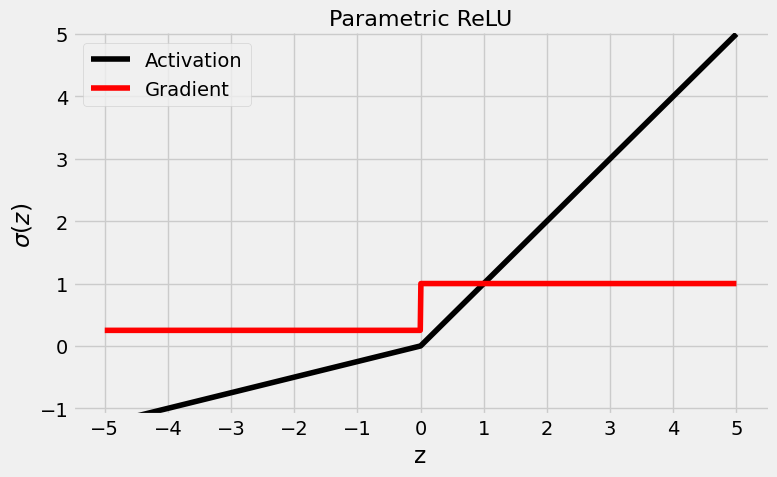

In [85]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

In [86]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.7500,  0.0000,  3.0000])

In [87]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluKernelBackward0>)

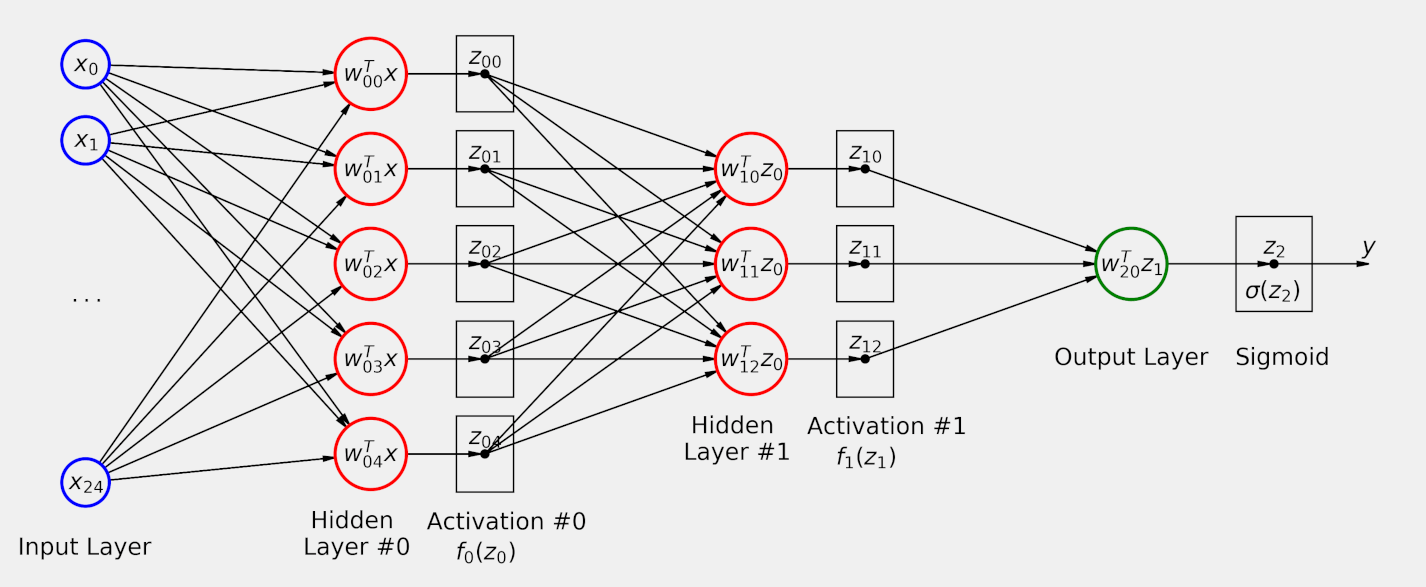

## **Model Configuration**

In [88]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

## **Model Training**

In [89]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

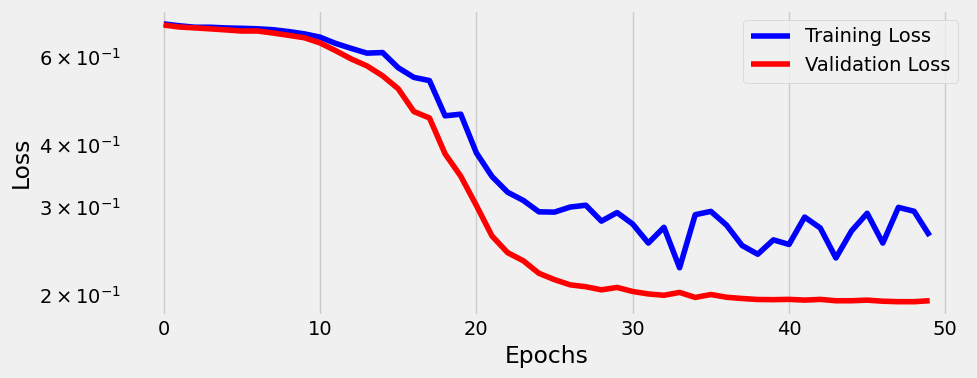

In [90]:
fig = sbs_relu.plot_losses()

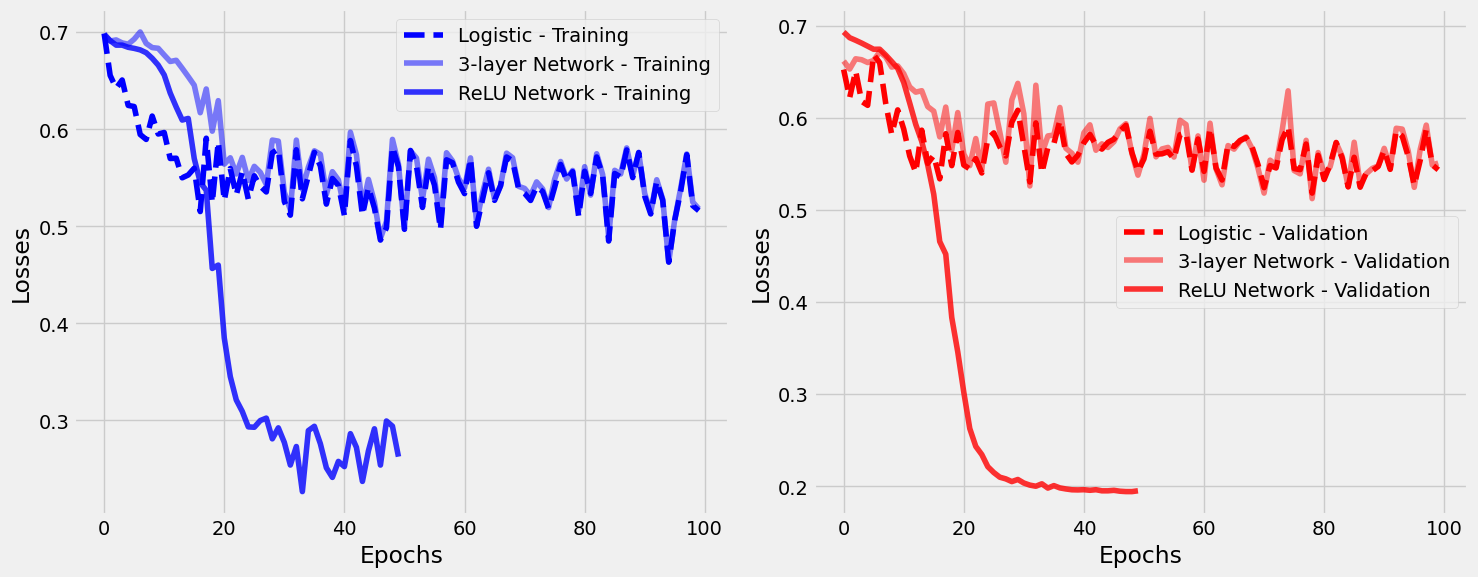

In [91]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)

# ***Putting It All Together***

In [92]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [93]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [94]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [95]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [96]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [97]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

In [111]:
def ComputeAccuracy(self, val_loader):
    sample = 0
    train_accuracy = 0
    for images, labels in val_loader:
        sample += images.shape[0]
        images = images.to(self.device)
        outputs = self.model(images)
        outputs = outputs.detach().cpu()
        train_accuracy += ((outputs >= 0.99) == labels).sum().item()
        
    return train_accuracy / sample

setattr(StepByStep, 'compute_accuracy', ComputeAccuracy)

In [112]:
accuracy = sbs_relu.compute_accuracy(val_loader)

In [113]:
accuracy

0.9666666666666667